# Ratio Image Creator

This notebook creates an image where the pixels are F475W / F814W.

In [1]:
# Imports
from pathlib import Path
from datetime import datetime

# Numerical Imports
import numpy as np

# Astropy Imports
from astropy.io import fits
from astropy.wcs import WCS

# Plotting
from matplotlib import pyplot as plt
from astropy.visualization import ManualInterval, LogStretch, ImageNormalize

## Load Data

In [2]:
# Path to Images
imgDir = Path('../Inpainted')

# Initialize Data Container
data = {}

# Loop through all files in the directory
for filter in [475, 814]:

    # Get the File Name
    fileName = imgDir / f'N3568-F{filter}W_drc_irn.fits'

    # Add Sub-Container
    data[filter] = {}

    # Open the FITS file
    with fits.open(fileName) as hduList:

        # Extract the data
        data[filter]['primary header'] = hduList[0].header
        data[filter]['image header']   = hduList['SCI'].header
        data[filter]['image wcs']      = WCS(hduList['SCI'].header)
        data[filter]['image']          = hduList['SCI'].data
        data[filter]['weight header']  = hduList['WHT'].header
        data[filter]['weight']         = hduList['WHT'].data
        data[filter]['error']          = hduList['WHT'].data**(-1/2)

/tmp/ipykernel_3852039/3804484743.py:26: RuntimeWarning: divide by zero encountered in power
  data[filter]['error']          = hduList['WHT'].data**(-1/2)


## Make the Ratio Image

In [3]:
# Initialize the Output HDU List
hduList = fits.HDUList()

# Add the Primary HDU
hduList.append(fits.PrimaryHDU())

# Add the Header Items that are the same for all filters
for hdrKey, hdrVal in data[475]['primary header'].items():
    if hdrVal == data[814]['primary header'][hdrKey]:
        hduList[0].header[hdrKey] = hdrVal

# Add Comments to the Primary HDU
hduList[0].header.add_comment('This file is the ratio of F475W/F814W images of NGC 3568.')
hduList[0].header.add_comment('Created by Will Waldron (UAH)')
hduList[0].header.add_comment(f'Created on {datetime.now().strftime("%Y-%m-%d")}')

# Add the Image Data
msk = (data[475]['image'] < 0) | (data[814]['image'] < 0)
ratio = data[475]['image'] / data[814]['image']
ratio[msk] = np.nan
hduList.append(fits.ImageHDU(
    data=ratio,
    name='SCI',
    header=data[475]['image wcs'].to_header()
))

# Add the Error
err  = (data[475]['error']/data[475]['image'])**2
err += (data[814]['error']/data[814]['image'])**2
err  = hduList['SCI'].data * np.sqrt(err)
err[msk] = np.nan
hduList.append(fits.ImageHDU(
    data=err,
    name='ERR',
    header=data[475]['image wcs'].to_header()
))

# Write the Output File
outputFile = 'N3568-F475W_F814W_ratio.fits'
hduList.writeto(outputFile, overwrite=True)

/tmp/ipykernel_3852039/3333128275.py:19: RuntimeWarning: divide by zero encountered in divide
  ratio = data[475]['image'] / data[814]['image']
/tmp/ipykernel_3852039/3333128275.py:29: RuntimeWarning: divide by zero encountered in divide
  err += (data[814]['error']/data[814]['image'])**2
/tmp/ipykernel_3852039/3333128275.py:29: RuntimeWarning: divide by zero encountered in divide
  err += (data[814]['error']/data[814]['image'])**2


## Plot the Ratio Image

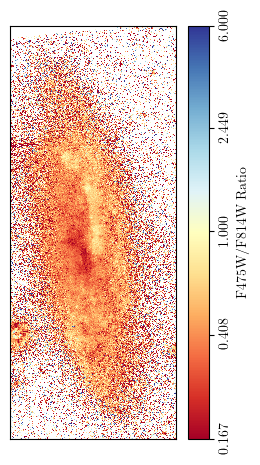

In [4]:
# Get the Normalization Interval
vmax = 6
vmin = vmax**-1
a    = vmax**2
norm = ImageNormalize(
    stretch=LogStretch(a),
    vmin=vmin, vmax=vmax,
    clip=False
)

# Create the Figure and Axes Objects
fig, ax = plt.subplots(figsize=(3, 4.75))

# Turn off the Grid Ticks
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks
ax.set_xticklabels([])  # Remove x-axis tick labels
ax.set_yticklabels([])  # Remove y-axis tick labels

# Plot the Image
imgPlot = ax.imshow(
    ratio[1500:7725, 3500:6000],
    origin='lower',
    cmap='RdYlBu',
    norm=norm,
    interpolation='nearest',
)

# Create the Colorbar
cbar = fig.colorbar(imgPlot, ax=ax, label='F475W/F814W Ratio')

# Set the colorbar ticks to be logarithmically spaced
cbar.set_ticks(np.geomspace(vmin, vmax, 5))  # Set custom ticks
cbar.ax.tick_params(axis='y', rotation=90)  # Rotate tick labels and adjust pad to center

# Adjust the position of the tick labels to be centered
for label in cbar.ax.yaxis.get_ticklabels():
    label.set_verticalalignment('center')

# Tighten Everything Up
fig.tight_layout()

# Save the Figure
fig.savefig('N3568-F475W_F814W_ratio.pdf', dpi=300, bbox_inches='tight')